In [1]:
"""
Electricity Markets and Energy System Planning

Specialisation Course Project
"""

# Imports
import pandas as pd
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
import matplotlib.pyplot as plt

file_name = 'Datasett_NO1_Cleaned_r5.xlsx'

In [2]:
# Data preprocessing
def inputData(file):
    data = {}
    excel_sheets = ['Producers', 'Consumers', 'Time_wind']
    for sheet in excel_sheets:
        df = pd.read_excel(file, sheet_name=sheet)
        df.index += 1
        data[sheet] = df.to_dict()

    df_prod = pd.DataFrame(data['Producers'])
    df_prod = df_prod.set_index('type')
    data['Producers'] = df_prod.to_dict()

    df_load = pd.DataFrame(data['Consumers'])
    df_load = df_load.set_index('load')
    data['Consumers'] = df_load.to_dict()

    df = pd.DataFrame(data['Time_wind'])
    df = df.set_index('Stage')
    df = df.reset_index(drop=True)
    data['Time_wind'] = df.iloc[0].to_dict()
    return data

data = inputData(file_name)

In [4]:
"""
Stochastic optimization model
DA = Day Ahead
RT = Real Time
"""

"""Set Variable Bounds"""
# Bounds for nuclear production DA
def limit_nuclear_DA(m):
    return m.P_min["nuclear"], m.P_max["nuclear"]
# Bounds for hydro production DA
def limit_hydro_DA(m):
    return m.P_min["hydro"], m.P_max["hydro"]
# Bounds for wind production DA
def limit_wind_DA(m):
    return m.P_min["wind"], m.P_max["wind"]
# Bounds for nuclear production RT
def limit_nuclear_RT(m, s):
    return m.P_min["nuclear"], m.P_max["nuclear"]
# Bounds for hydro production RT
def limit_hydro_RT(m, s):
    return m.P_min["hydro"], m.P_max["hydro"]
# Bounds for wind production RT
def limit_wind_RT(m, s):
    return m.P_min["wind"], m.P_max["wind"]
# Bounds for rationing RT
def rationing_limits(m, s):
    return 0, m.demand

"""Constraints"""
# Nuclear production cannot change between DA and RT
def locked_nuclear_prod(m, s):
    return m.nuclear_DA == m.nuclear_RT[s]
# Load balance DA
def load_balance_DA(m):
    return m.nuclear_DA + m.hydro_DA + m.wind_DA == m.demand
# Load balance RT
def load_balance_RT(m, s):
    return m.hydro_RT[s] + m.wind_prod_RT[s] + m.nuclear_RT[s] + m.rationing[s] >= m.demand
# Hydro production RT cannot exceed DA production + reserved capacity
def hydro_upper_RT(m, s):
    return m.hydro_RT[s] <= m.hydro_DA + m.hydro_res_DA
# Hydro production RT cannot be lower than DA production - reserved capacity
def hydro_lower_RT(m, s):
    return m.hydro_RT[s] >= m.hydro_DA - m.hydro_res_DA
# Hydro reserve must be positive
def hydro_res_min(m):
    return m.hydro_res_DA >= 0

"""Objective Function"""
def ObjFunction(m):
    production_cost_DA = m.hydro_res_DA * m.C_res + m.hydro_DA * m.MC['hydro'] + m.nuclear_DA * m.MC['nuclear']
    production_cost_RT = sum(m.prob[s] * (m.MC['hydro'] * (m.hydro_RT[s]-m.hydro_DA)) for s in m.S)
    rationing_cost = sum(m.prob[s] * m.C_rat * m.rationing[s]for s in m.S)
    return production_cost_DA + production_cost_RT + rationing_cost

def modelSetup_1(data):
    m                   = pyo.ConcreteModel()
    """Sets"""
    m.G                 = pyo.Set(initialize=list(data['Producers']['p_max'].keys()))
    m.S                 = pyo.Set(initialize=list(data['Time_wind'].keys()))
    """Parameters"""
    m.C_rat             = pyo.Param(initialize=data['Consumers']['rationing_cost']['Load 1'])
    m.C_res             = pyo.Param(initialize=data['Producers']['reserve_cost']['hydro'])
    m.demand            = pyo.Param(initialize=data['Consumers']['consumption']['Load 1'])
    m.prob              = pyo.Param(m.S, initialize={'low': 1/3, 'med': 1/3, 'high': 1/3})
    m.MC                = pyo.Param(m.G, initialize=data['Producers']['marginal_cost'])
    m.P_max             = pyo.Param(m.G, initialize=data['Producers']['p_max'])
    m.P_min             = pyo.Param(m.G, initialize=data['Producers']['p_min'])
    m.P_wind            = pyo.Param(m.S, initialize=data['Time_wind'])
    m.wind_DA           = sum(m.prob[s] * m.P_wind[s] for s in m.S)
    """Variables"""
    m.nuclear_DA        = pyo.Var(bounds=limit_nuclear_DA, within=pyo.NonNegativeReals)
    m.hydro_DA          = pyo.Var(bounds=limit_hydro_DA, within=pyo.NonNegativeReals)
    m.hydro_res_DA      = pyo.Var(within=pyo.NonNegativeReals)
    m.nuclear_RT        = pyo.Var(m.S, bounds=limit_nuclear_RT, within=pyo.NonNegativeReals)
    m.hydro_RT          = pyo.Var(m.S, bounds=limit_hydro_RT, within=pyo.NonNegativeReals)
    m.wind_prod_RT      = pyo.Var(m.S, within=pyo.NonNegativeReals)
    m.rationing         = pyo.Var(m.S, bounds=rationing_limits, within=pyo.NonNegativeReals)
    """Constraints"""
    m.LockedNuclearProd = pyo.Constraint(m.S, rule=locked_nuclear_prod)
    m.LoadBalance_DA    = pyo.Constraint(rule=load_balance_DA)
    m.LoadBalance_RT    = pyo.Constraint(m.S, rule=load_balance_RT)
    m.HydroUpper_RT     = pyo.Constraint(m.S, rule=hydro_upper_RT)
    m.HydroLower_RT     = pyo.Constraint(m.S, rule=hydro_lower_RT)
    m.WindProdRT        = pyo.Constraint(m.S, rule=lambda m, s: m.wind_prod_RT[s] == m.P_wind[s])
    m.HydroResMin       = pyo.Constraint(rule=hydro_res_min)
    """Objective Function"""
    m.obj               = pyo.Objective(rule=ObjFunction, sense=pyo.minimize)
    return m


def SolveModel(m):
    opt = SolverFactory("gurobi")
    m.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
    res = opt.solve(m, load_solutions=True)
    return res, m

def DisplayModelResults(m):
    # return m.pprint()
    return print(m.display(), m.dual.display())

m = modelSetup_1(data)
res, m = SolveModel(m)
DisplayModelResults(m)

Model unknown

  Variables:
    nuclear_DA : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 : 150.0 :   150 : False : False : NonNegativeReals
    hydro_DA : Size=1, Index=None
        Key  : Lower : Value              : Upper : Fixed : Stale : Domain
        None :     0 : 54.666666666666686 :    60 : False : False : NonNegativeReals
    hydro_res_DA : Size=1, Index=None
        Key  : Lower : Value             : Upper : Fixed : Stale : Domain
        None :     0 : 5.333333333333314 :  None : False : False : NonNegativeReals
    nuclear_RT : Size=3, Index=S
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        high :     0 : 150.0 :   150 : False : False : NonNegativeReals
         low :     0 : 150.0 :   150 : False : False : NonNegativeReals
         med :     0 : 150.0 :   150 : False : False : NonNegativeReals
    hydro_RT : Size=3, Index=S
        Key  : Lower : Value              : Upper : Fixed : Stale : Do


------ Iteration 1 ------
X_hat (Hydro Reserve DA): 0.01
Set [0]
Phi {0: 2001.6666666666665}
lambda {0: 43.33333333333333}
x_hat {0: 0.01}

--- Master Problem Results ---
Nuclear DA: 150.00
Hydro DA: 54.40
Hydro Reserve DA: 0.01
Objective Function (Master-Problem): -6117.75

--- Sub-Problem Results ---
Scenario low - Wind: 34.50
Scenario low - Hydro RT: 54.41
Scenario low - Rationing: 11.09
Scenario med - Wind: 45.60
Scenario med - Hydro RT: 54.40
Scenario med - Rationing: 0.00
Scenario high - Wind: 55.90
Scenario high - Hydro RT: 54.39
Scenario high - Rationing: 0.00
Objective Function (Sub-Problem): 2001.67

--- Total Objective Value ---
-6117.75 - 2001.67 = -8119.42

------ Iteration 2 ------
X_hat (Hydro Reserve DA): 5.60
Set [0, 1]
Phi {0: 2001.6666666666665, 1: 1815.3333333333335}
lambda {0: 43.33333333333333, 1: 43.33333333333333}
x_hat {0: 0.01, 1: 5.599999999999994}

--- Master Problem Results ---
Nuclear DA: 150.00
Hydro DA: 54.40
Hydro Reserve DA: 5.60
Objective Function (M

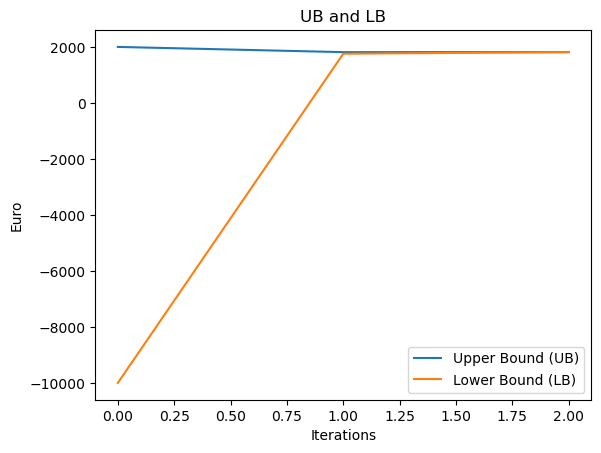

In [5]:
"""
Benders Decomposition
"""

"""Master problem formulation (DA)"""
def Obj_1st(m):
    return m.nuclear_DA * m.MC['nuclear'] + m.hydro_DA * m.MC['hydro'] + m.hydro_res_DA * m.C_res + m.alpha
"""Constraints"""
# Load balance
def DA_load_balance(m):
    return m.nuclear_DA + m.hydro_DA + m.wind_DA == m.demand
# Nuclear production limits
def nuclear_lim(m):
    return m.P_min['nuclear'], m.nuclear_DA, m.P_max['nuclear']
# Hydro production limits
def hydro_lim(m):
    return m.P_min['hydro'], m.hydro_DA + m.hydro_res_DA , m.P_max['hydro']
# Minimum reserve for hydro
def hydro_res_min(m):
    return m.hydro_res_DA >= 0.01 
# Create cuts
def CreateCuts(m, c):
    return m.alpha >= m.Phi[c] - m.Lambda[c] * (m.hydro_res_DA - m.X_hat[c])

def masterModel(data, Cuts):
    """Setup Master Problem Model"""
    m = pyo.ConcreteModel()
    """Sets"""
    m.G             = pyo.Set(initialize=list(data['Producers']['p_max'].keys()))
    """Parameters"""
    m.MC            = pyo.Param(m.G, initialize=data['Producers']['marginal_cost'])
    m.C_res         = pyo.Param(initialize=data['Producers']['reserve_cost']['hydro'])
    m.demand        = pyo.Param(initialize=data['Consumers']['consumption']['Load 1'])
    m.P_max         = pyo.Param(m.G, initialize=data['Producers']['p_max'])
    m.P_min         = pyo.Param(m.G, initialize=data['Producers']['p_min'])
    m.wind_DA       = pyo.Param(initialize=data['Time_wind']['med'])
    """Variables"""
    m.nuclear_DA    = pyo.Var(within=pyo.NonNegativeReals)
    m.hydro_DA      = pyo.Var(within=pyo.NonNegativeReals)
    m.hydro_res_DA  = pyo.Var(within=pyo.NonNegativeReals)
    m.alpha         = pyo.Var(bounds=(-10000, 10000))
    """Cuts"""
    m.Cut           = pyo.Set(initialize=Cuts["Set"])  # Set for cuts
    m.Phi           = pyo.Param(m.Cut, initialize=Cuts["Phi"])  # Parameter for Phi (Objective cost)
    m.Lambda        = pyo.Param(m.Cut, initialize=Cuts["lambda"])  # Parameter for lambda (dual value of reserve)
    m.X_hat         = pyo.Param(m.Cut, initialize=Cuts["x_hat"])  # Parameter for reserved hydro
    """Constraints"""
    m.DA_balance    = pyo.Constraint(rule=DA_load_balance)
    m.nuclear_lim   = pyo.Constraint(rule=nuclear_lim)
    m.hydro_lim     = pyo.Constraint(rule=hydro_lim)
    m.hydro_res_min = pyo.Constraint(rule=hydro_res_min)
    m.CreateCuts    = pyo.Constraint(m.Cut, rule=CreateCuts)
    """Objective Function"""
    m.obj           = pyo.Objective(rule=Obj_1st, sense=pyo.minimize)
    return m

"""Sub-problem formulation"""
def Obj_2nd(m):
    return sum(m.prob[s] * (m.hydro_RT[s] * m.MC['hydro'] + m.rationing[s] * m.C_rat) for s in m.S)
"""Constraints"""
# Load balance
def RT_load_balance(m, s):
    return m.hydro_RT[s] + m.wind_RT[s] + m.nuclear_RT[s] + m.rationing[s] >= m.demand
def hydro_link_upper_RT(m, s):
    """Link upper bound for hydro_RT with hydro_DA + hydro_res_DA"""
    return m.hydro_RT[s] <= m.hydro_DA + m.X_hat
def hydro_link_lower_RT(m, s):
    """Link lower bound for hydro_RT: hydro_RT >= hydro_DA - hydro_res_DA"""
    return m.hydro_RT[s] >= m.hydro_DA - m.X_hat

def subModel(data, X_hat, DA_values, probability):
    """Setup Sub Problem Model"""
    m = pyo.ConcreteModel()
    """Sets"""
    m.G             = pyo.Set(initialize=list(data['Producers']['p_max'].keys()))
    m.S             = pyo.Set(initialize=list(data['Time_wind'].keys()))
    """Parameters"""
    m.MC            = pyo.Param(m.G, initialize=data['Producers']['marginal_cost'])
    m.C_rat         = pyo.Param(initialize=data['Consumers']['rationing_cost']["Load 1"])
    m.demand        = pyo.Param(initialize=data['Consumers']['consumption']['Load 1'])
    m.nuclear_RT    = pyo.Param(m.S, initialize=DA_values["nuclear_DA"])
    m.wind_RT       = pyo.Param(m.S, initialize=data['Time_wind'])
    m.prob          = pyo.Param(m.S, initialize=probability)
    m.hydro_DA      = pyo.Param(initialize=DA_values["hydro_DA"])
    m.X_hat         = pyo.Param(initialize=X_hat)
    """Variables"""
    m.hydro_RT      = pyo.Var(m.S, within=pyo.NonNegativeReals)
    m.rationing     = pyo.Var(m.S, bounds=(0, 250), within=pyo.NonNegativeReals)
    """Constraints"""
    m.RT_balance    = pyo.Constraint(m.S, rule=RT_load_balance)
    m.hydro_high_RT = pyo.Constraint(m.S, rule=hydro_link_upper_RT)
    m.hydro_low_RT  = pyo.Constraint(m.S, rule=hydro_link_lower_RT)
    """Objective Function"""
    m.obj           = pyo.Objective(rule=Obj_2nd, sense=pyo.minimize)
    return m

def manageCuts(Cuts, m):
    """Add new cut to existing dictionary of cut information"""
    cut = len(Cuts["Set"])
    Cuts['Set'].append(cut)
    Cuts['Phi'][cut] = pyo.value(m.obj)
    Cuts['lambda'][cut] = sum(m.dual[m.RT_balance[s]]for s in m.S)  # Retrieve duals for each scenario
    Cuts['x_hat'][cut] = pyo.value(m.X_hat)
    return Cuts

def display_results_benders(m_1st, m_2nd):
    """Display the results for the current iteration"""
    print("\n--- Master Problem Results ---")
    print(f"Nuclear DA: {pyo.value(m_1st.nuclear_DA):.2f}")
    print(f"Hydro DA: {pyo.value(m_1st.hydro_DA):.2f}")
    print(f"Hydro Reserve DA: {pyo.value(m_1st.hydro_res_DA):.2f}")
    print(f"Objective Function (Master-Problem): {pyo.value(m_1st.obj):.2f}")
    print("\n--- Sub-Problem Results ---")
    for s in m_2nd.S:
        print(f"Scenario {s} - Wind: {pyo.value(m_2nd.wind_RT[s]):.2f}")  # Print wind for each scenario
        print(f"Scenario {s} - Hydro RT: {pyo.value(m_2nd.hydro_RT[s]):.2f}")
        print(f"Scenario {s} - Rationing: {pyo.value(m_2nd.rationing[s]):.2f}")
    print(f"Objective Function (Sub-Problem): {pyo.value(m_2nd.obj):.2f}")
    print("\n--- Total Objective Value ---")
    print(f"{pyo.value(m_1st.obj):.2f} - {pyo.value(m_2nd.obj):.2f} = {(pyo.value(m_1st.obj) - pyo.value(m_2nd.obj)):.2f}")

def benders(data):
    """Setup for benders decomposition"""
    Cuts = {}
    Cuts["Set"] = []
    Cuts["Phi"] = {}
    Cuts["lambda"] = {}
    Cuts["x_hat"] = {}

    graph = {}
    graph["UB"] = {}
    graph["LB"] = {}

    for i in range(10):
        m_1st = masterModel(data, Cuts)
        Solve(m_1st)

        X_hat = pyo.value(m_1st.hydro_res_DA)
        DA_values = {"nuclear_DA": pyo.value(m_1st.nuclear_DA), "hydro_DA": pyo.value(m_1st.hydro_DA)}

        probability = {'low': 1/3, 'med': 1/3, 'high': 1/3}
        m_2nd = subModel(data, X_hat, DA_values, probability)
        results, m_2nd = Solve(m_2nd)

        # Check if the subproblem was solved successfully
        if results.solver.termination_condition == 'infeasible':
            print("Subproblem infeasible. Skipping iteration.")
            break

        Cuts = manageCuts(Cuts, m_2nd)

        # Store upper and lower bounds for plotting
        graph['LB'][i] = pyo.value(m_1st.alpha)
        graph['UB'][i] = pyo.value(m_2nd.obj)

        # Display the results of this iteration
        print(f"\n------ Iteration {i + 1} ------")
        print(f"X_hat (Hydro Reserve DA): {X_hat:.2f}")
        for component in Cuts:
            print(component, Cuts[component])
        display_results_benders(m_1st, m_2nd)

        """Convergence check"""
        if abs(graph['UB'][i] - graph['LB'][i]) <= 0.001:
            break

    # Plotting the result
    plt.plot(graph['UB'].keys(), graph['UB'].values(), label='Upper Bound (UB)')
    plt.plot(graph['LB'].keys(), graph['LB'].values(), label='Lower Bound (LB)')
    plt.xlabel('Iterations')
    plt.ylabel('Euro')
    plt.title('UB and LB')
    plt.legend()
    plt.show()


def Solve(m):
    opt = SolverFactory("gurobi")
    m.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
    res = opt.solve(m, load_solutions=True)
    return res, m

benders(data)


In [ ]:
"""
Stochastic Dynamic Programming
"""

